# Split Neural Network

[Split Neural Network (SplitNN)][1] is a kind of distributed learning approach. It uses multiple splits of NN to train with different portions of features and then aggregated by another NN. It is very similar to the stacking ensemble of multiple NNs. Let's see if this approach works.

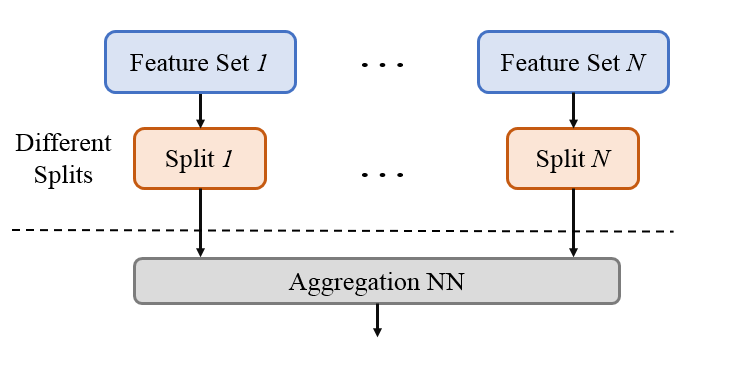

[1]:https://arxiv.org/pdf/1812.00564.pdf

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import gc
import datetime
import numpy as np
np.random.seed(42)
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss
from scipy.optimize import minimize
from tqdm.notebook import tqdm
from time import time

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

# Data Preparation

In [ ]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

ss = pd.read_csv('../input/lish-moa/sample_submission.csv')
ss_2 = ss.copy()
ss_3 = ss.copy()
ss_blend = ss.copy()

cols = [c for c in ss.columns.values if c != 'sig_id']

In [ ]:
def preprocess(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

In [ ]:
top_feats = [  0,   1,   2,   3,   5,   6,   8,   9,  10,  11,  12,  14,  15,
        16,  18,  19,  20,  21,  23,  24,  25,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  44,  45,  46,
        48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        63,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 180,
       181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 195,
       197, 198, 199, 202, 203, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 218, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230,
       231, 232, 233, 234, 236, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 263, 265, 266, 268, 270, 271, 272, 273, 275, 276, 277, 279,
       282, 283, 286, 287, 288, 289, 290, 294, 295, 296, 297, 299, 300,
       301, 302, 303, 304, 305, 306, 308, 309, 310, 311, 312, 313, 315,
       316, 317, 320, 321, 322, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 338, 339, 340, 341, 343, 344, 345, 346, 347,
       349, 350, 351, 352, 353, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 368, 369, 370, 371, 372, 374, 375, 376, 377,
       378, 379, 380, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
       392, 393, 394, 395, 397, 398, 399, 400, 401, 403, 405, 406, 407,
       408, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
       436, 437, 438, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 468, 469, 471, 472, 473, 474, 475, 476, 477, 478, 479, 482,
       483, 485, 486, 487, 488, 489, 491, 492, 494, 495, 496, 500, 501,
       502, 503, 505, 506, 507, 509, 510, 511, 512, 513, 514, 516, 517,
       518, 519, 521, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547,
       549, 550, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 569, 570, 571, 572, 573, 574, 575, 577, 580,
       581, 582, 583, 586, 587, 590, 591, 592, 593, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 605, 607, 608, 609, 611, 612, 613, 614,
       615, 616, 617, 619, 622, 623, 625, 627, 630, 631, 632, 633, 634,
       635, 637, 638, 639, 642, 643, 644, 645, 646, 647, 649, 650, 651,
       652, 654, 655, 658, 659, 660, 661, 662, 663, 664, 666, 667, 668,
       669, 670, 672, 674, 675, 676, 677, 678, 680, 681, 682, 684, 685,
       686, 687, 688, 689, 691, 692, 694, 695, 696, 697, 699, 700, 701,
       702, 703, 704, 705, 707, 708, 709, 711, 712, 713, 714, 715, 716,
       717, 723, 725, 727, 728, 729, 730, 731, 732, 734, 736, 737, 738,
       739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751,
       752, 753, 754, 755, 756, 758, 759, 760, 761, 762, 763, 764, 765,
       766, 767, 769, 770, 771, 772, 774, 775, 780, 781, 782, 783, 784,
       785, 787, 788, 790, 793, 795, 797, 799, 800, 801, 805, 808, 809,
       811, 812, 813, 816, 819, 820, 821, 822, 823, 825, 826, 827, 829,
       831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 844, 845,
       846, 847, 848, 850, 851, 852, 854, 855, 856, 858, 860, 861, 862,
       864, 867, 868, 870, 871, 873, 874]

print(len(top_feats))

# Model Functions

In [ ]:
def create_model(num_columns, hidden_units, dropout_rate, learning_rate):
        
    inp1 = tf.keras.layers.Input(shape = (num_columns, ))
    x1 = tf.keras.layers.BatchNormalization()(inp1)
    
    for i, units in enumerate(hidden_units[0]):
        x1 = tfa.layers.WeightNormalization(tf.keras.layers.Dense(units, activation = 'elu'))(x1)
        x1 = tf.keras.layers.Dropout(dropout_rate[0])(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        
    inp2 = tf.keras.layers.Input(shape = (num_columns, ))
    x2 = tf.keras.layers.BatchNormalization()(inp2)
    
    for i, units in enumerate(hidden_units[1]):
        x2 = tfa.layers.WeightNormalization(tf.keras.layers.Dense(units, activation = 'elu'))(x2)
        x2 = tf.keras.layers.Dropout(dropout_rate[1])(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        
    inp3 = tf.keras.layers.Input(shape = (num_columns, ))
    x3 = tf.keras.layers.BatchNormalization()(inp3)
    
    for i, units in enumerate(hidden_units[2]):
        x3 = tfa.layers.WeightNormalization(tf.keras.layers.Dense(units, activation = 'elu'))(x3)
        x3 = tf.keras.layers.Dropout(dropout_rate[2])(x3)
        x3 = tf.keras.layers.BatchNormalization()(x3)
        
    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dropout(dropout_rate[3])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    for units in hidden_units[3]:
        
        x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(units, activation = 'elu'))(x)
        x = tf.keras.layers.Dropout(dropout_rate[4])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation = 'sigmoid'))(x)
    
    model = tf.keras.models.Model(inputs = [inp1, inp2, inp3], outputs = out)
    
    model.compile(optimizer = tfa.optimizers.Lookahead(tf.optimizers.Adam(learning_rate), sync_period = 10), 
                  loss = 'binary_crossentropy')
    
    return model

In [ ]:
hidden_units = [[2048, 512, 2048], 
                [512, 1024, 512], 
                [512, 1024, 2048, 1024, 512], 
                [1024, 1024]]

dropout_rate = [0.4, 0.3, 0.45, 0.3, 0.4]

size = int(np.ceil(0.8 * len(train.columns.values)))

model = create_model(size, hidden_units, dropout_rate, 1e-3)
tf.keras.utils.plot_model(model, show_shapes = False, show_layer_names= True,
                          rankdir = 'TB', expand_nested = False, dpi = 96)

# Train Model

For each split, we use 80\% of top features as input.

In [ ]:
hidden_units = [[2048, 512, 2048], 
                [512, 1024, 512], 
                [512, 1024, 2048, 1024, 512], 
                [1024, 1024]]

dropout_rate = [0.4, 0.3, 0.45, 0.3, 0.4]

size = int(np.ceil(0.8 * len(top_feats)))

res = train_targets.copy()
ss.loc[:, train_targets.columns] = 0
res.loc[:, train_targets.columns] = 0

N_STARTS = 3

for seed in range(N_STARTS):
    
    split_cols = []
    for _ in range(len(hidden_units) - 1):
        split_cols.append(np.random.choice(top_feats, size))
        
    for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits = 5, random_state = seed, shuffle = True).split(train_targets, train_targets)):
        
        start_time = time()
        
        x_tr = [train.values[tr][:, split_cols[0]], train.values[tr][:, split_cols[1]], train.values[tr][:, split_cols[2]]]
        x_val = [train.values[te][:, split_cols[0]], train.values[te][:, split_cols[1]], train.values[te][:, split_cols[2]]]
        y_tr, y_val = train_targets.astype(float).values[tr], train_targets.astype(float).values[te]
        x_tt = [test_features.values[:, split_cols[0]], test_features.values[:, split_cols[1]], test_features.values[:, split_cols[2]]]
        
        model = create_model(size, hidden_units, dropout_rate, 1e-3)
        rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 0, 
                                min_delta = 1e-4, min_lr = 1e-5, mode = 'min')
        ckp = ModelCheckpoint(f'split_nn.hdf5', monitor = 'val_loss', verbose = 0, 
                              save_best_only = True, save_weights_only = True, mode = 'min')
        es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 10, mode = 'min', 
                           baseline = None, restore_best_weights = True, verbose = 0)
        history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), 
                            epochs = 100, batch_size = 128, callbacks = [rlr, ckp, es], verbose = 0)
        hist = pd.DataFrame(history.history)
        model.load_weights(f'split_nn.hdf5')
        ss.loc[:, train_targets.columns] += model.predict(x_tt, batch_size = 128)
        res.loc[te, train_targets.columns] += model.predict(x_val, batch_size = 128)
        print(f'[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}] Split NN: Seed {seed}, Fold {n}:', hist['val_loss'].min())
        
        K.clear_session()
        del model, history, hist
        x = gc.collect()
        
ss.loc[:, train_targets.columns] /= ((n + 1) * N_STARTS)
res.loc[:, train_targets.columns] /= N_STARTS

In [ ]:
print(f'Split NN OOF Metric: {log_loss_metric(train_targets, res)}')
res.loc[train['cp_type'] == 1, train_targets.columns] = 0
ss.loc[test['cp_type'] == 1, train_targets.columns] = 0
print(f'Split NN OOF Metric with postprocessing: {log_loss_metric(train_targets, res)}')

# Submission

In [ ]:
ss.to_csv('submission.csv', index = False)